In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os
import peakutils
import datetime
import warnings
from jupyterthemes import jtplot

import logging

logging.getLogger().setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")
from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_fits import *
from xps.xps_bg import *

In [3]:
jtplot.style('grade3', context='talk', grid=False, ticks=True, fscale=1.5)
# plt.rcParams['errorbar.capsize'] = 8

In [4]:
asf = dict({'C_1s' : 0.296, 'O_1s' : 0.711, 'N_1s' : 0.477, 'Ba_3d' : 7.49,
            'Cu_2p' : 5.321, 'Cl_2p' : 0.891})

### Background subtraction class (dev) 

In [5]:
class Background2(object):
    @staticmethod
    def bg_handler(xp, region,  *args, **kwargs):
        x = xp.dfx[region].dropna().energy.values
        y = xp.dfx[region].dropna().counts.values
        return x, y

    @staticmethod
    def edit_xp(xp, region, x, y, ybg, ax = None):
        if ax == None: ax = plt.gca()
        col = plot_region(xp, region, lb=region, ax=ax).get_color()
        ax.plot(x, ybg, '--', color=col, label='__nolabel__')
        cosmetics_plot(ax=ax)
        
        dfnew = pd.DataFrame({'energy' : x, 'counts' : y - ybg})
        xpNew = deepcopy(xp)
        xpNew.dfx[region] = dfnew
        return xpNew

    def dec_linear(self, xp, region, *args, **kwargs):
        x, y = self.bg_handler(xp, region, *args, **kwargs)

        ybg = peakutils.baseline(y, deg=1)
        return self.edit_xp(xp, region, x, y, ybg)
    
    def dec_shirley(self, xp, region, maxit=40, **kwargs):
        kwargs['maxit'] = maxit
        x,y = self.bg_handler(xp, region, **kwargs)
        ybg = shirley_loop(x,y, **kwargs)
        return self.edit_xp(xp, region, x, y, ybg)
    
    def dec_2shirley(self, xp, region, xlim, maxit=40, **kwargs):
        x, y = self.bg_handler(xp, region, **kwargs)
        y1 = y[ x >= xlim ]
        x1 = x[ x >= xlim ]
        y2 = y[ x <= xlim ]
        x2 = x[ x <= xlim ]

        ybg1 = shirley_loop(x1, y1, maxit = maxit)#, flag_plot=flag_plot, ax = ax)
        ybg2 = shirley_loop(x2, y2, maxit = maxit)#, flag_plot=flag_plot, ax = ax)
        ybg = np.append(np.append(ybg1[:-1], np.average([ybg1[-1], ybg2[0]])), ybg2[1:] )
        return self.edit_xp(xp, region, x, y, ybg, **kwargs)

NameError: name 'trim_exps' is not defined

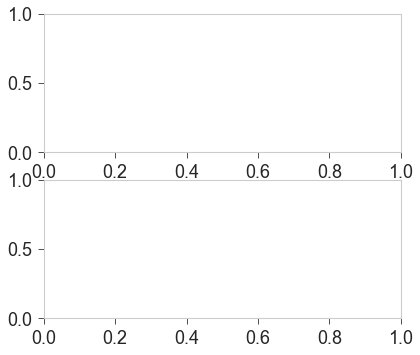

In [6]:
# Background2().dec_linear(xp=experiments[0], region='C_1s')
fig, ax = plt.subplots(2)
BG2 = Background2()
bg2 = BG2.dec_2shirley(xp=trim_exps[0], region='overview_', 
                       xlim = 346, maxit=50, ax=ax[0])
bg2 = BG2.dec_linear(xp=trim_exps[0], 
                     region='overview_', ax=ax[1])

In [ ]:
def test_bg_subpots()
    fig, ax = plt.subplots(2)
    BG2 = Background2()
    bg2 = BG2.dec_2shirley(xp=trim_exps[0], region='overview_', 
                           xlim = 346, maxit=50, ax=ax[0])
    bglin = BG2.dec_linear(xp=trim_exps[0], 
                         region='overview_', ax=ax[1])

    assert len(ax[0].get_lines()) <= 2, "Too many lines in lin_bg subplot"
    assert len(ax[0].get_lines()) >= 2, "Not enough lines in lin_bg subplot"

In [ ]:
BG2 = Background2()
bg2 = BG2.dec_2shirley(xp=trim_exps[0], region='overview_', 
                       xlim = 346, maxit=50, ax=ax[0])
x,y = BG2.bg_handler(xp=trim_exps[0], region='overview_')
x,ybg = BG2.bg_handler(bg2, region='overview_')
lentest = len(np.where(y < ybg)[0])
assert lentest == 0, "Background over signal in %i points"%lentest


In [ ]:
BG2 = Background2()
bg2 = BG2.dec_linear(xp=trim_exps[0], region='overview_')
x,y = BG2.bg_handler(xp=trim_exps[0], region='overview_')
x,ybg = BG2.bg_handler(bg2, region='overview_')
lentest = len(np.where(y < ybg)[0])
assert lentest == 0, "Background over signal in %i points"%lentest


In [ ]:
def test_method(method):
    BG2 = Background2()
    bg2 = method(xp=trim_exps[0], region='overview_')
    x,y = BG2.bg_handler(xp=trim_exps[0], region='overview_')
    x,ybg = BG2.bg_handler(bg2, region='overview_')
    lentest = len(np.where(y < ybg)[0])
    assert lentest == 0, "Background over signal in %i points"%lentest
test_method(Background2().dec_linear)

## Pre-processing of data FBI on Cu policrystal
1- ALI deposition FBI-metOH
2- Sublimations in UHV (19th Oct 2020)

Note: 16 min sublim was performed after reseting detector voltage, so the counts are much higher. Thus we cannot use it to estimate the depth of the layer

## Import data

In [5]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_metOH/**/*.xy'
files = glob.glob(path, recursive=True)
files.sort()
files_new = []
for f in files:
    if (' ' not in f) and ('/proc' not in f):
        files_new.append(f)

files = files_new[1:]

for f in files:
    print(f)

/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_metOH/2020_09_11_Cu/20200911_Cu_clean3.xy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_metOH/2020_09_11_Cu/20200915_Cu_metOH_400pulses.xy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_metOH/2020_09_11_Cu/20200916_Cu_FBI_metOH_400pulses.xy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_metOH/2020_09_11_Cu/20200917_Cu_FBI_metOH_400pulses_BaCl_subl_30min.xy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_metOH/2020_09_11_Cu/20200917_Cu_FBI_metOH_400pulses_BaCl_subl_3h.xy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_metOH/2020_09_11_Cu/20200917_Cu_FBI_metOH_400pulses_annealing.xy


In [6]:
experiments = [xps_data_import(path=f) for f in files]
experiments[3].name

'Cu_FBI_metOH_400pulses_BaCl_subl_30min'

## Bg subtraction

In [8]:
region = 'Cu_2p'

Text(0.5, 1.0, 'Cu 2p')

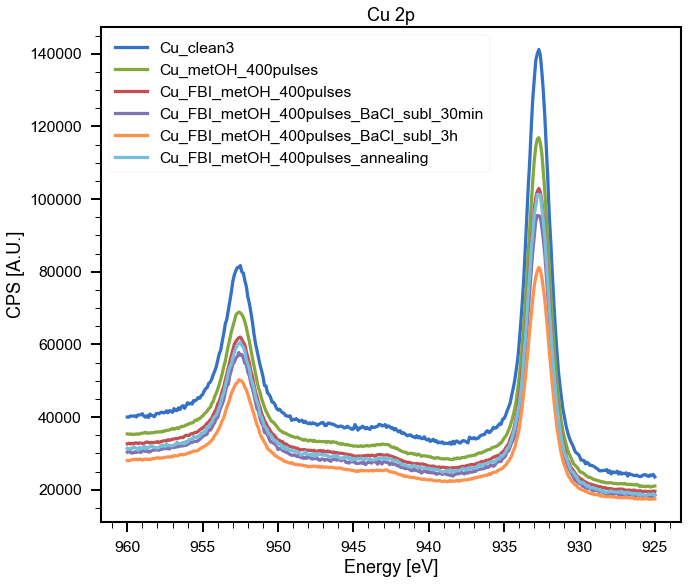

In [9]:
trim_exps = []
# for xp in experiments[:3]+experiments[4:]:
for xp in experiments:
    try:
        xp_new = crop_spectrum(xp, region=region, eup=960, edw=925)
        trim_exps.append(xp_new)
        plot_region(xp_new, region)
    except KeyError as e:
        print(e, ' in ', xp.name)
        trim_exps.append(xp)
cosmetics_plot()
plt.title('Cu 2p')

### Subtract double shirley to all Cu regions

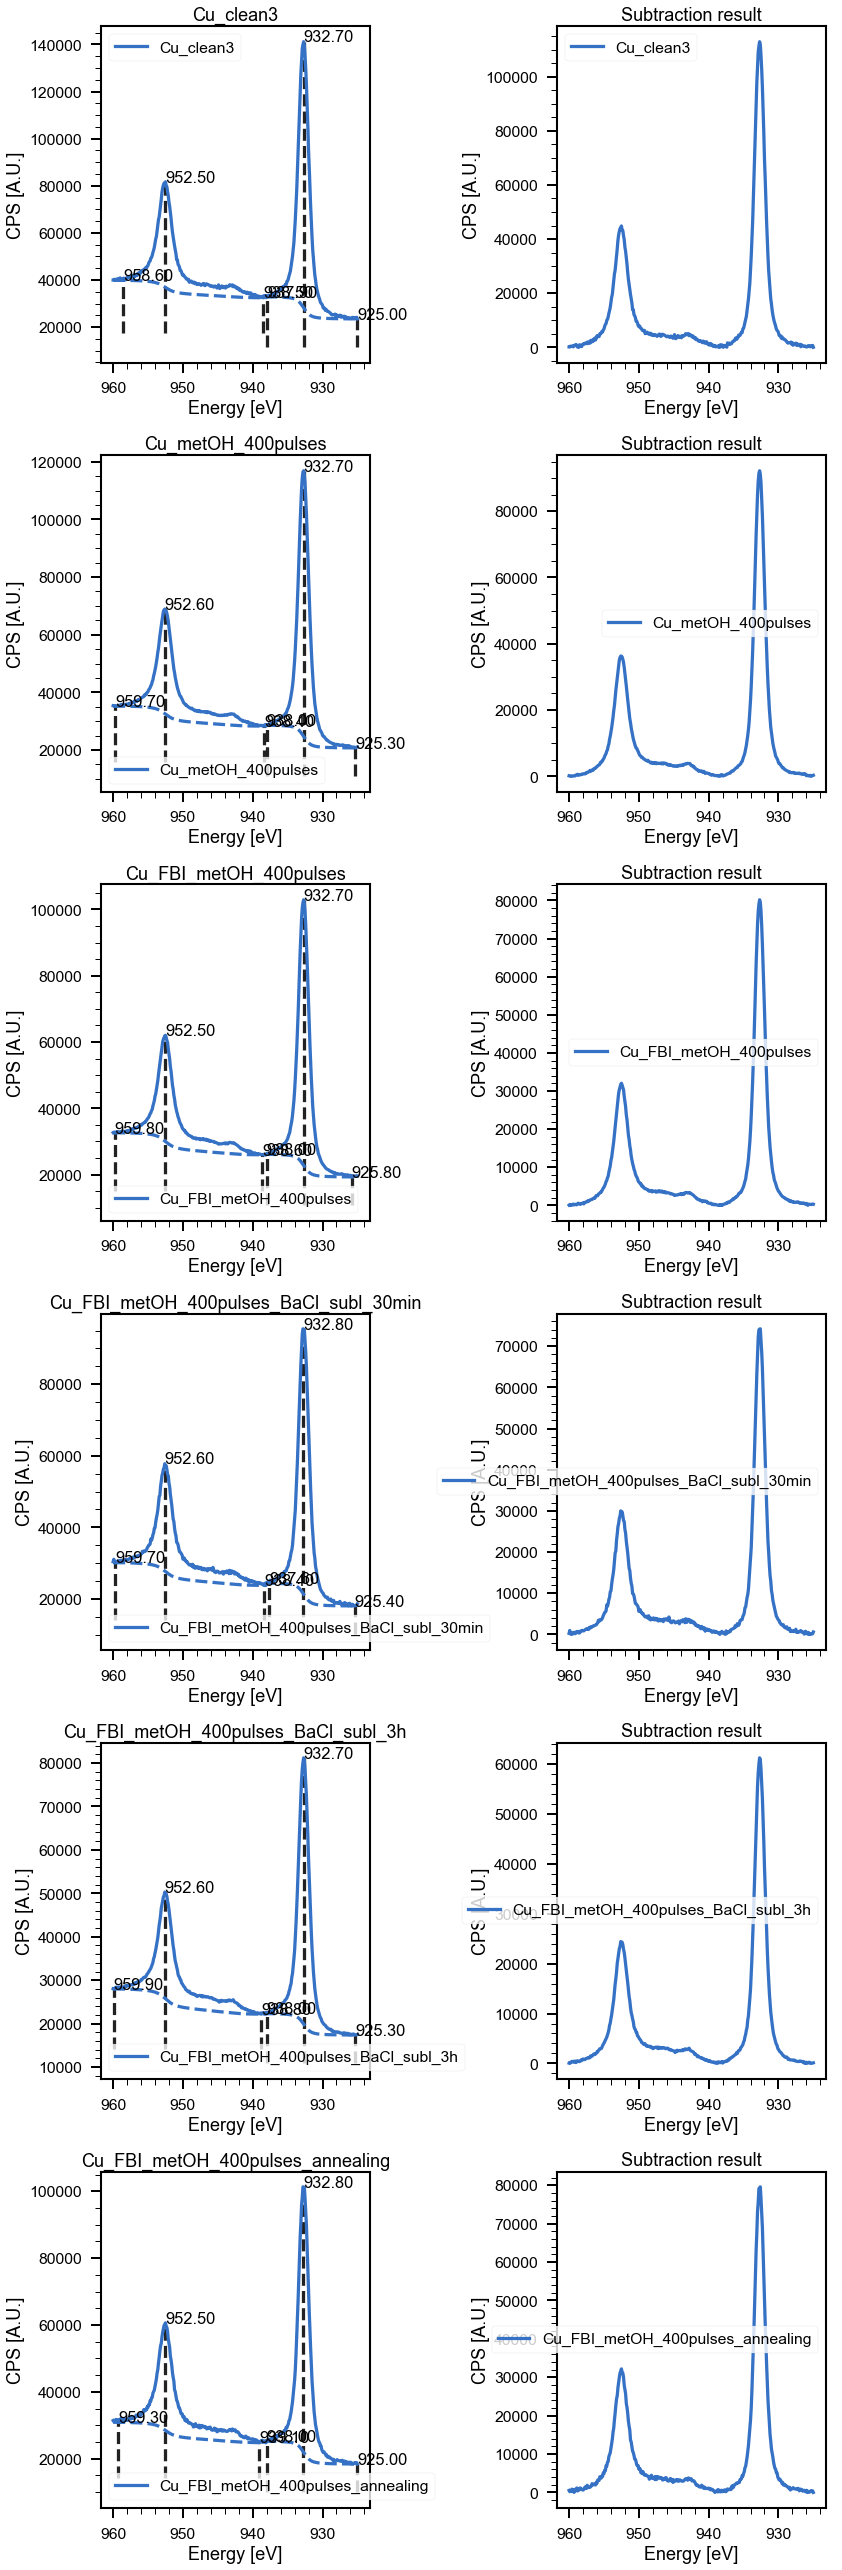

In [10]:
region = 'Cu_2p'

bg_exps = region_2bg_subtract(trim_exps, region=region, xlim=938)

### Bulk subtract background

Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline


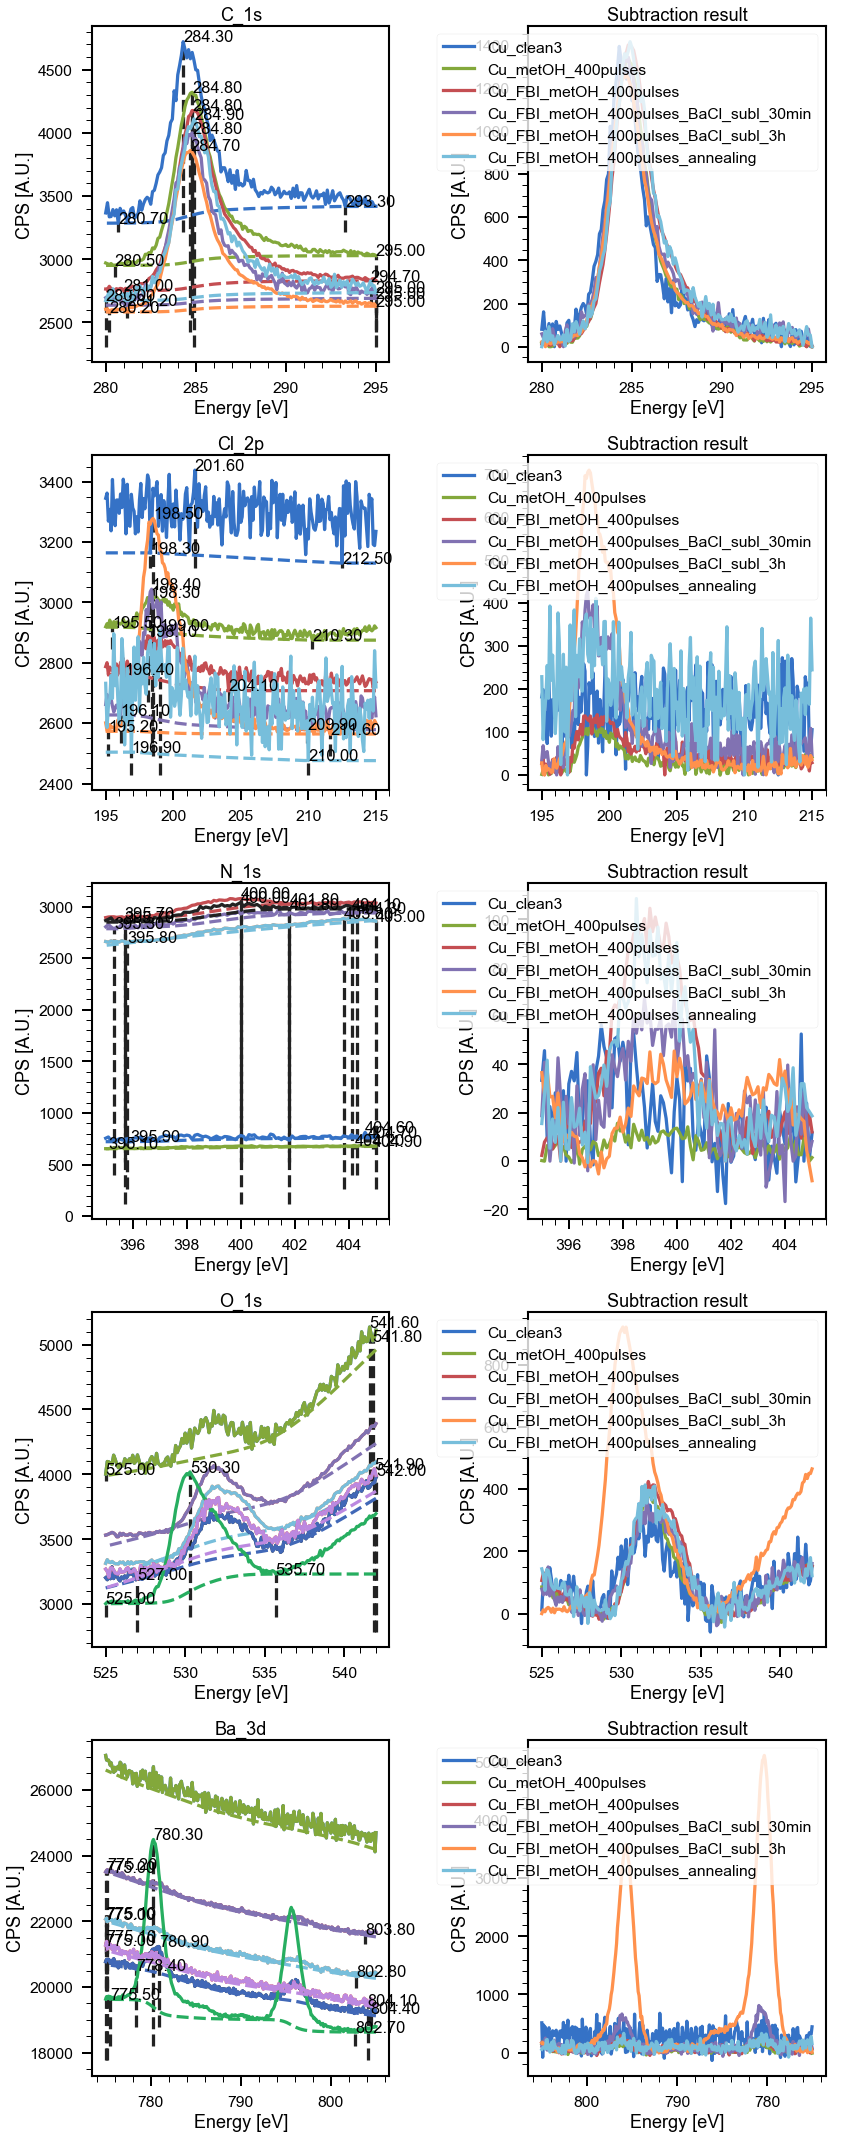

In [11]:
regions = ['C_1s', 'Cl_2p', 'N_1s', 'O_1s', 'Ba_3d']
bg_exps = bulk_bg_subtract(bg_exps, regions)

#### Plot result of bulk subtract

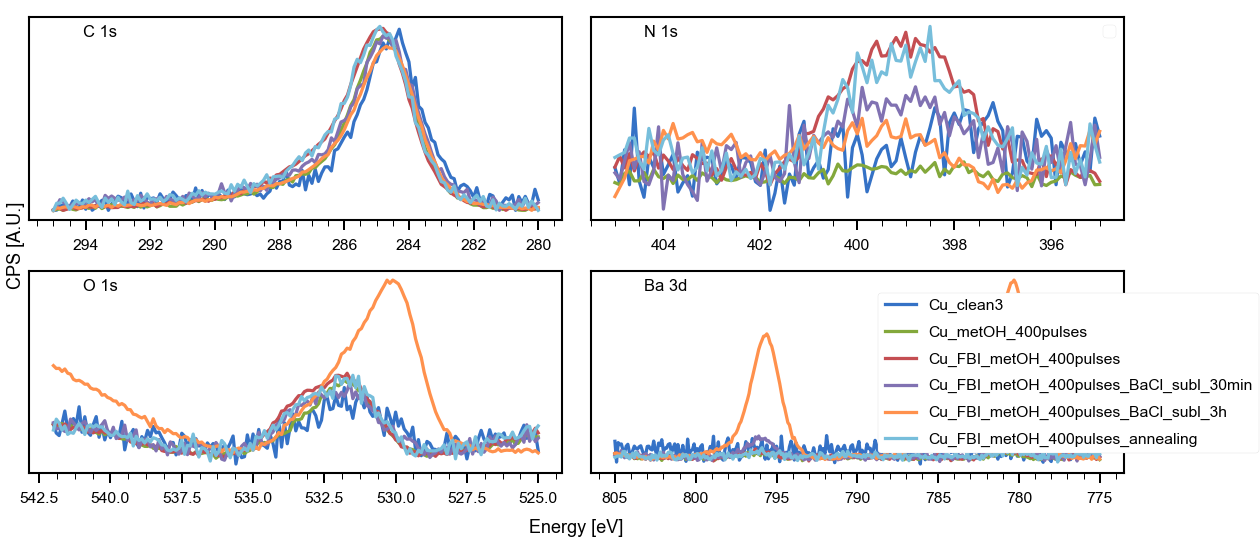

In [12]:
plot_xp_regions(bg_exps, ['C_1s', 'N_1s', 'O_1s', 'Ba_3d'], ncols=2);

### Subtract linear and shirley bg to all O 1s regions

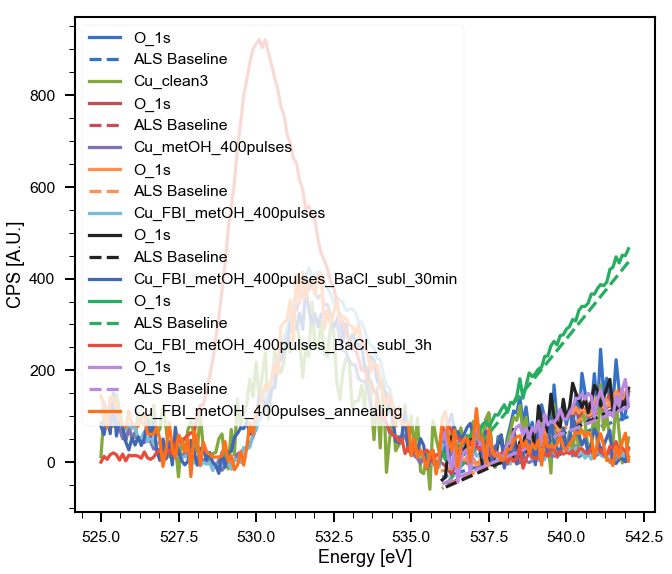

In [13]:
for xp in bg_exps:
    fix_tail_bg(xp, 'O_1s', edw=536, inplace=True)

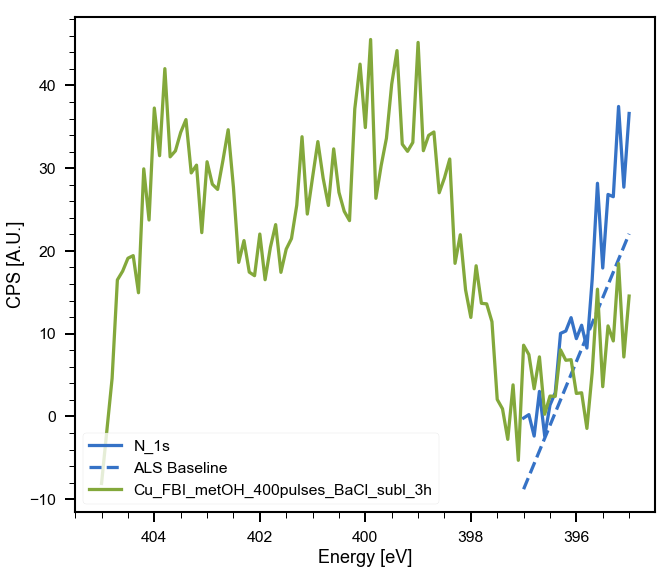

In [14]:
region = 'N_1s'
fix_tail_bg(bg_exps[4], region, eup=397, inplace=True);

### Compress Ba 3d, Cl 2p regions

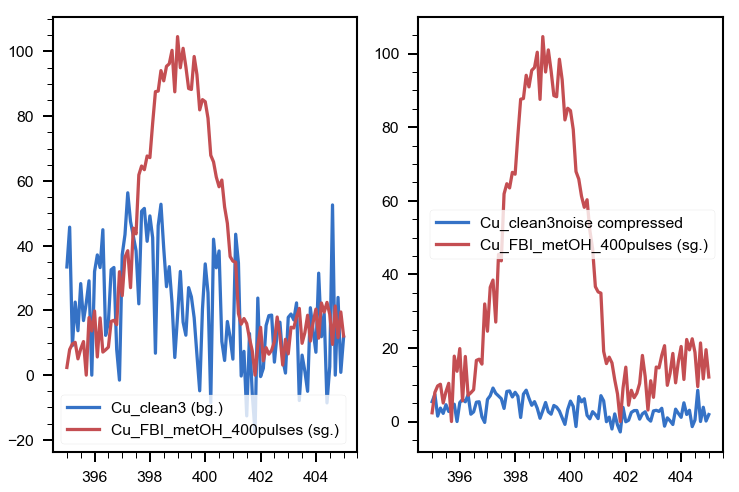

In [15]:
region= 'N_1s'
compress_noisy_region(bg_exps[0], xpRef=bg_exps[2], region=region, inplace=True);

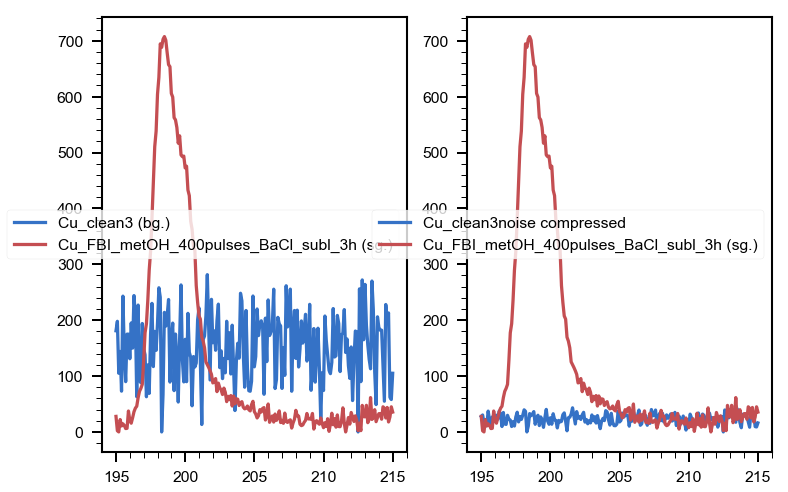

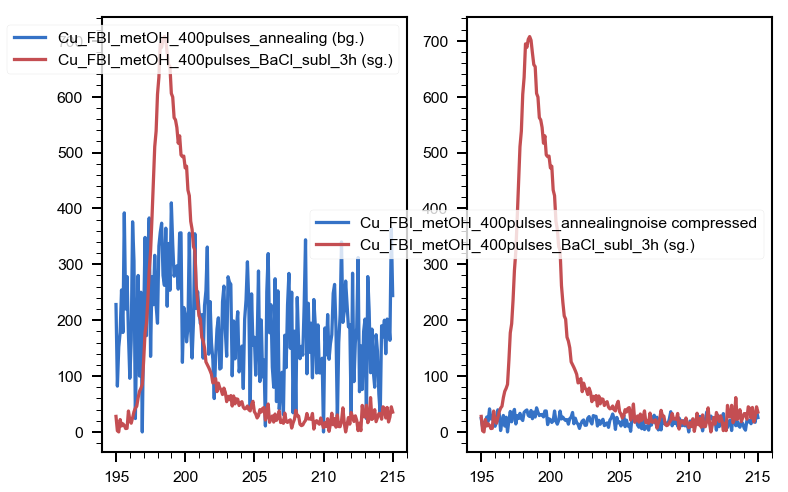

In [16]:
region= 'Cl_2p'
compress_noisy_region(xp=bg_exps[0], xpRef=bg_exps[4], region=region, inplace=True);
compress_noisy_region(xp=bg_exps[5], xpRef=bg_exps[4], region=region, inplace=True);

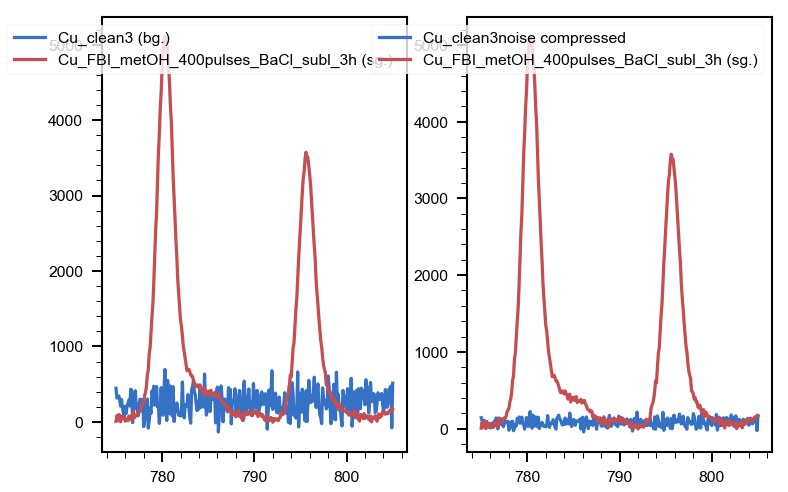

In [17]:
region= 'Ba_3d'
compress_noisy_region(xp=bg_exps[0], xpRef=bg_exps[4], region=region, inplace=True);

In [84]:
bg_exps[4].dfx[region] = xp_bg.dfx[region]

In [85]:
bg_exps[4].dfx[region].max()

properties
energy    805.000000
counts    642.890574
dtype: float64

## Scale to Cu 2p

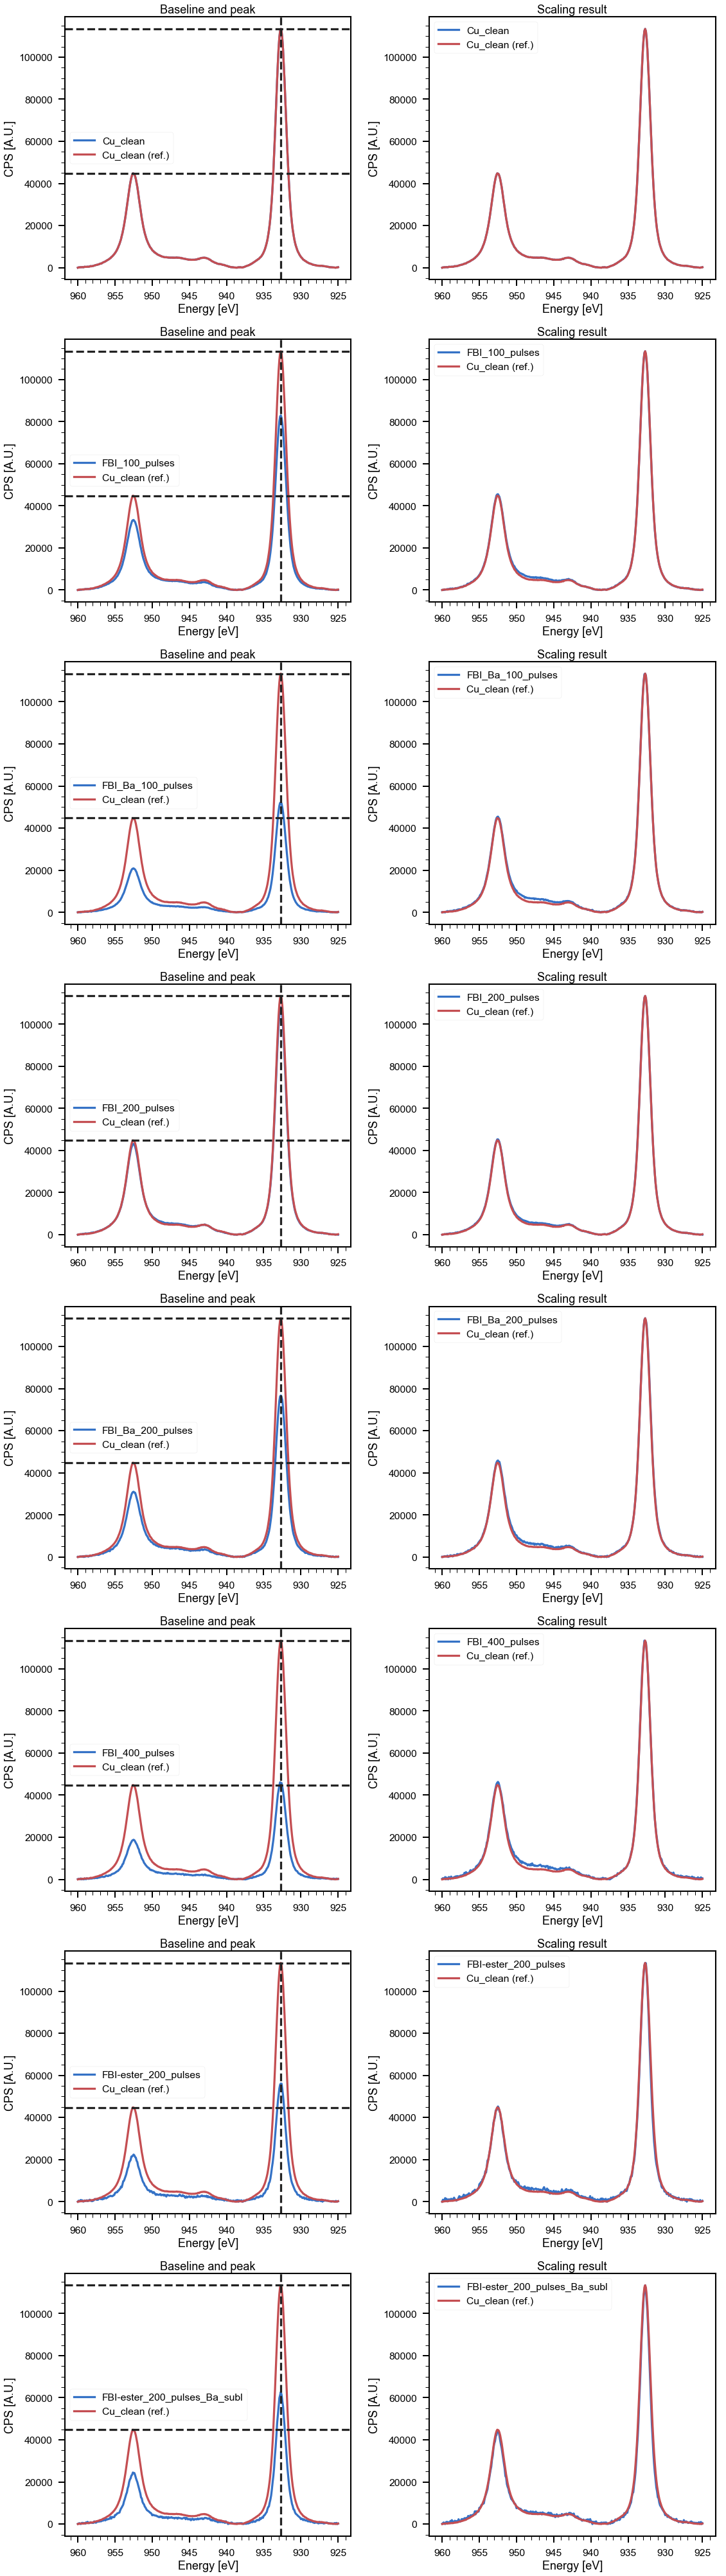

In [71]:
scaled_exps = scale_and_plot_spectra(bg_exps, indRef=0, region = 'Cu_2p')

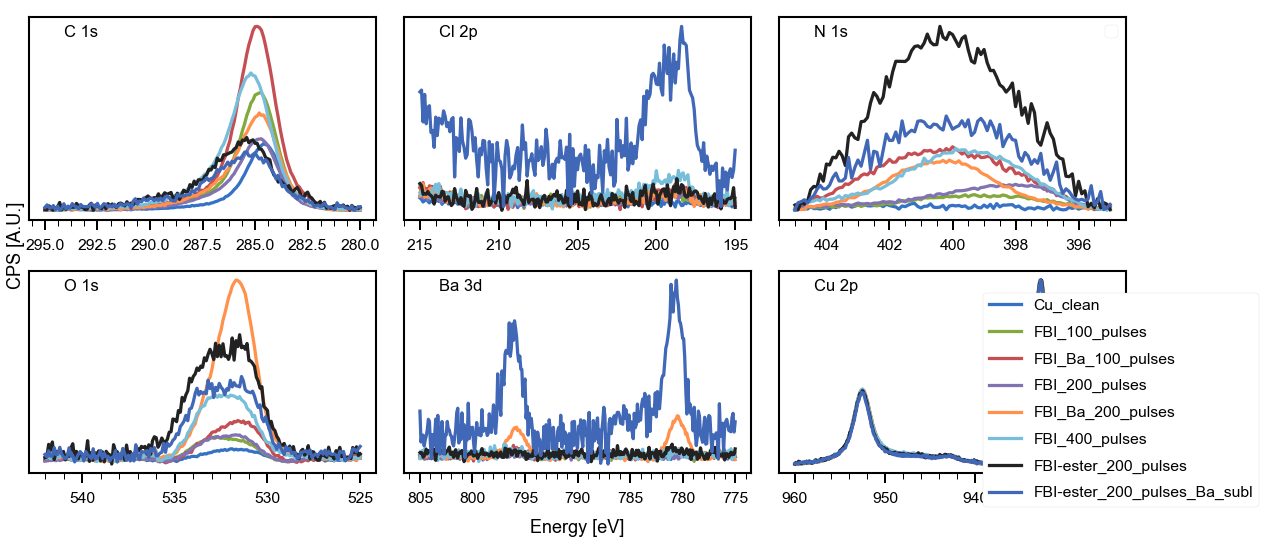

In [74]:
plot_xp_regions(scaled_exps, regions+['Cu_2p']);

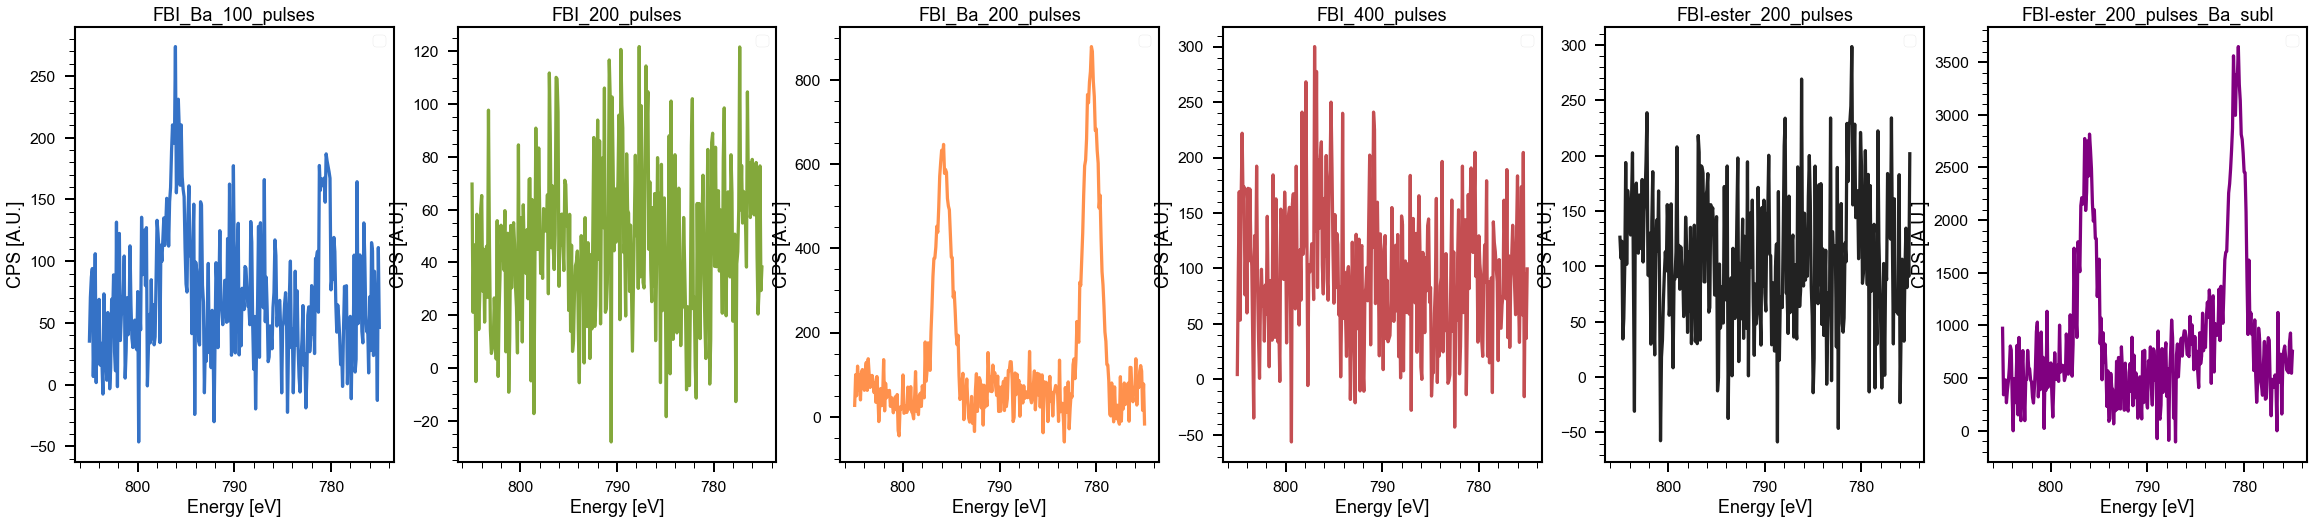

In [78]:
region = 'Ba_3d'
colors = ['b', 'g', 'y', 'r', 'k', 'purple']
fig, ax = plt.subplots(1, 6, figsize=(40, 8))
for i,xp in enumerate(scaled_exps[2:8]):
    li = plot_region(xp, 'Ba_3d', ax=ax[i], lb='__nolabel__')
    if len(colors) > 0: li.set_color(colors[i])
    ax[i].set_title(xp.name)
    cosmetics_plot(ax=ax[i])
# plt.tight_layout()

## Store processed experiments

In [79]:
import os
for xpu, xps in zip(bg_exps, scaled_exps):
    filepath, filename = os.path.split(xpu.path)
    newpath = filepath + '/proc/'
    try:
        os.mkdir(newpath)
    except FileExistsError: pass
#     print(newpath + filename)
    write_processed_xp(newpath + filename.replace('.xy', '.uxy'), xpu)
    write_processed_xp(newpath + filename.replace('.xy', '.sxy'), xps)